## Import libraries

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

## Loading data

In [2]:
df = pd.read_csv("../SQL/data/forecasting_prophet_daily_revenue.csv", sep=",")

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [3]:
df.shape

(611, 2)

In [4]:
df.head(1)

,order_date,daily_revenue
0,2016-10-03,595.14


## Duplicates/nulls/negative values check

In [5]:
df.duplicated(keep='first').sum()

0

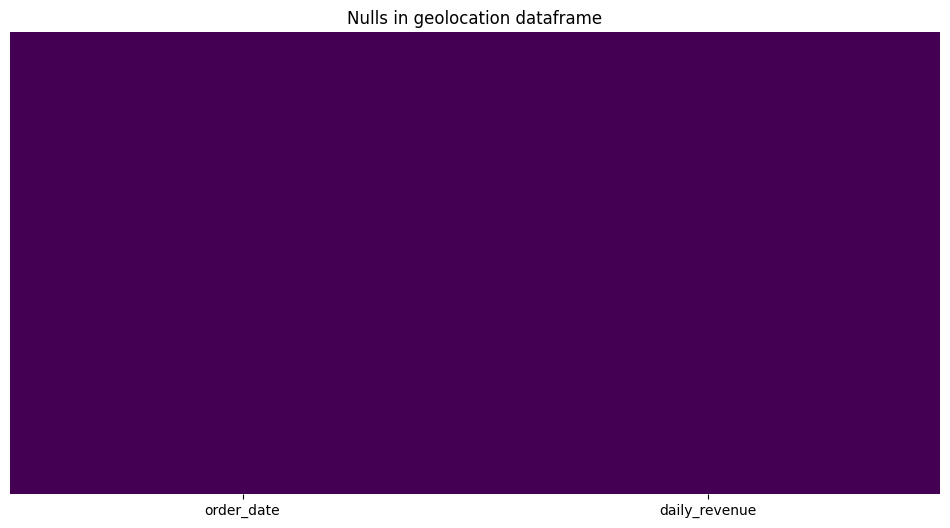

In [6]:
plt.figure(figsize=(12, 6))
sns.heatmap(df.isnull(), cbar=False, cmap='viridis', yticklabels=False)
plt.title('Nulls in geolocation dataframe')
plt.savefig('../artifacts/images/forecasting_EDA/isnull_forecasting.png', dpi=300, bbox_inches='tight')
plt.show()

In [7]:
for col in df.columns:
    n_missing = df[col].isna().sum()
    print(f"{col}: {n_missing} values")

order_date: 0 values
daily_revenue: 0 values


In [8]:
df.dtypes

order_date        object
daily_revenue    float64
dtype: object

In [9]:
columns = [1]
negatives = (df.iloc[:,columns]< 0).any()
negatives

daily_revenue    False
dtype: bool

##### NOTE: *There aren't any negative values or nulls.*

## Converting columns types

In [10]:
df.head(1)

,order_date,daily_revenue
0,2016-10-03,595.14


In [11]:
df.dtypes

order_date        object
daily_revenue    float64
dtype: object

In [12]:
df["order_date"] = pd.to_datetime(df["order_date"], format='%Y-%m-%d')

In [13]:
df.dtypes

order_date       datetime64[ns]
daily_revenue           float64
dtype: object

In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 611 entries, 0 to 610
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   order_date     611 non-null    datetime64[ns]
 1   daily_revenue  611 non-null    float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 9.7 KB


In [15]:
df.describe().select_dtypes(include=['float64', 'int64', 'int32']).map(lambda x: f'{x:0.2f}')

,daily_revenue
count,611.00
mean,25240.00
min,19.62
25%,14871.17
50%,23280.78
75%,33648.81
max,175250.94
std,14345.41


##### NOTE: *Object converted to datetime.*

## Visualizations

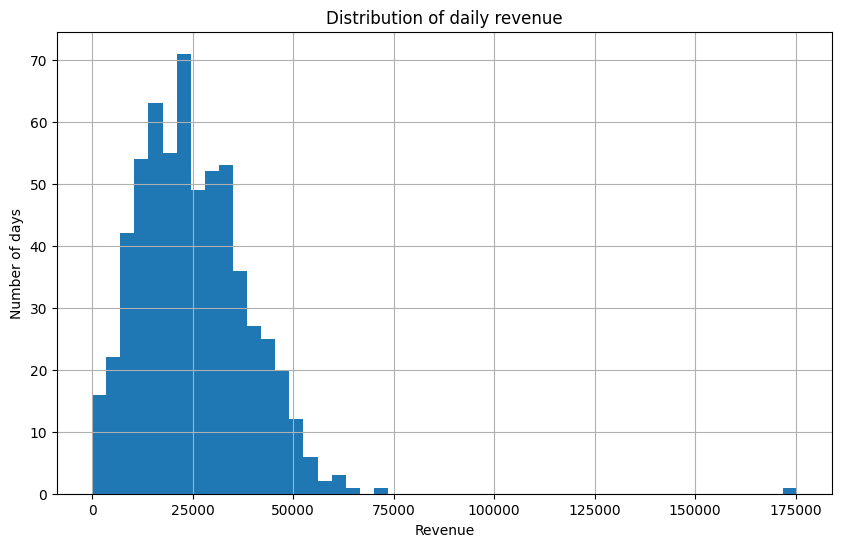

In [16]:
plt.figure(figsize=(10,6))
df['daily_revenue'].hist(bins=50)
plt.title("Distribution of daily revenue")
plt.xlabel("Revenue")
plt.ylabel("Number of days")
plt.savefig("../artifacts/images/forecasting_EDA/revenue_hist.png", dpi=300, bbox_inches="tight")
plt.show()

##### NOTE: *The distribution of daily revenue is slightly right-skewed with a short tail. This indicates that most days have relatively stable sales, with only a few high-revenue days. A log transformation is not strictly necessary for forecasting, as the skewness is mild and Prophet can handle it.*

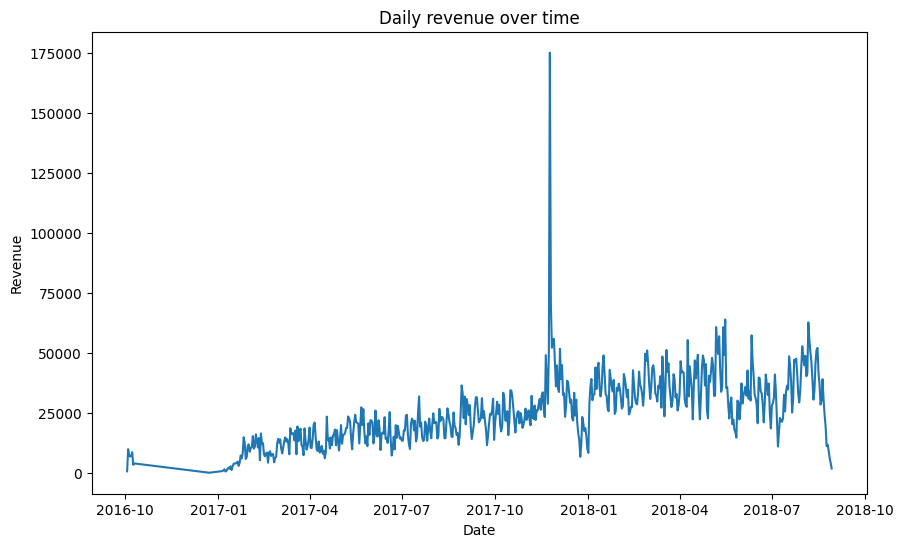

In [17]:
plt.figure(figsize=(10,6))
plt.plot(df['order_date'], df['daily_revenue'], color="tab:blue")
plt.title("Daily revenue over time")
plt.xlabel("Date")
plt.ylabel("Revenue")
plt.savefig("../artifacts/images/forecasting_EDA/revenue_trend.png", dpi=300, bbox_inches="tight")
plt.show()

In [18]:
print(df.nlargest(5, "daily_revenue"))

    order_date  daily_revenue
332 2017-11-24      175250.94
333 2017-11-25       70684.27
505 2018-05-16       63960.93
587 2018-08-06       62728.23
496 2018-05-07       60805.33


##### NOTE: *The time series shows a clear upward trend in sales over time, likely due to the growing popularity of the platform. The earliest data from 2016 appear inconsistent, suggesting incomplete records. Sales variability increases as the platform scales. A significant outlier is observed on November 24th, which could be related to Black Friday, but it is not repeated annually, making it a one-time anomaly. Interestingly, December shows weaker performance after the spike, contrary to typical holiday sales patterns. Towards the end of the series, the data appear to abruptly drop, suggesting missing or incomplete data rather than an actual business collapse.*

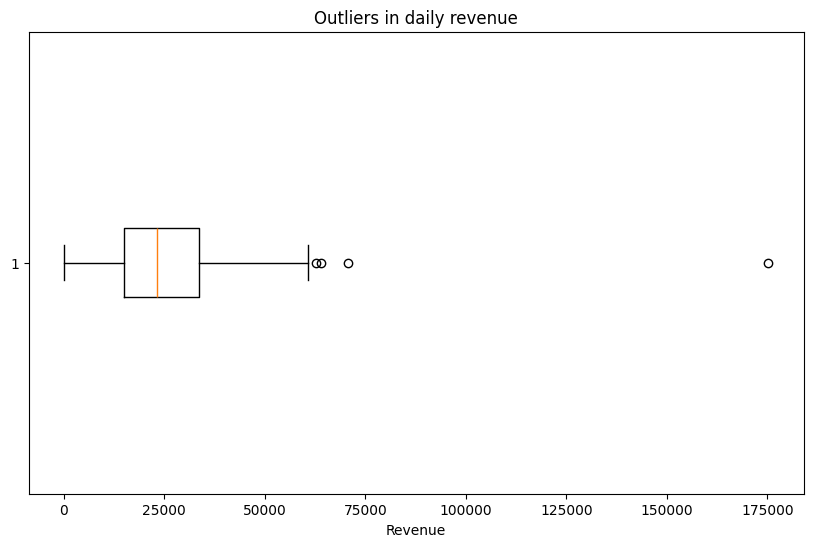

In [19]:
plt.figure(figsize=(10,6))
plt.boxplot(df['daily_revenue'], vert=False)
plt.title("Outliers in daily revenue")
plt.xlabel("Revenue")
plt.savefig("../artifacts/images/forecasting_EDA/revenue_boxplot.png", dpi=300, bbox_inches="tight")
plt.show()

##### NOTE: *The boxplot confirms that most daily revenue values are concentrated within a relatively narrow range, with only one major extreme outlier (November 24th). Apart from this, the dataset does not display frequent anomalies.*

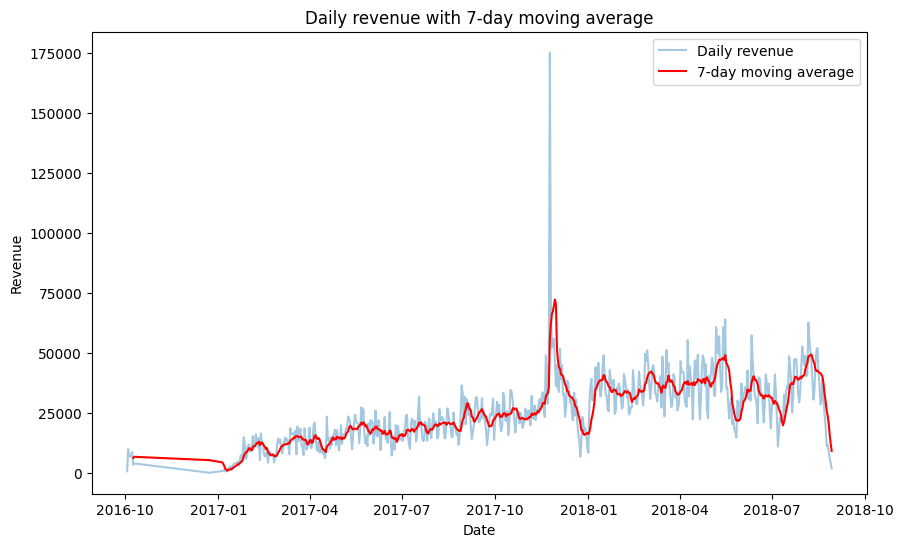

In [20]:
df['revenue_ma7'] = df['daily_revenue'].rolling(7).mean()
plt.figure(figsize=(10,6))
plt.plot(df['order_date'], df['daily_revenue'], alpha=0.4, label="Daily revenue")
plt.plot(df['order_date'], df['revenue_ma7'], color="red", label="7-day moving average")
plt.legend()
plt.title("Daily revenue with 7-day moving average")
plt.xlabel("Date")
plt.ylabel("Revenue")
plt.savefig("../artifacts/images/forecasting_EDA/revenue_moving_avg.png", dpi=300, bbox_inches="tight")
plt.show()

##### NOTE: *The rolling average does not reveal a strong seasonal pattern in the data. Instead, it highlights the overall upward growth trend and confirms that the November 24th spike is not part of a recurring seasonal cycle.*

C:\Users\Krzychu\AppData\Local\Temp\ipykernel_9640\994724037.py:1: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly = df.resample("M", on="order_date")['daily_revenue'].sum()


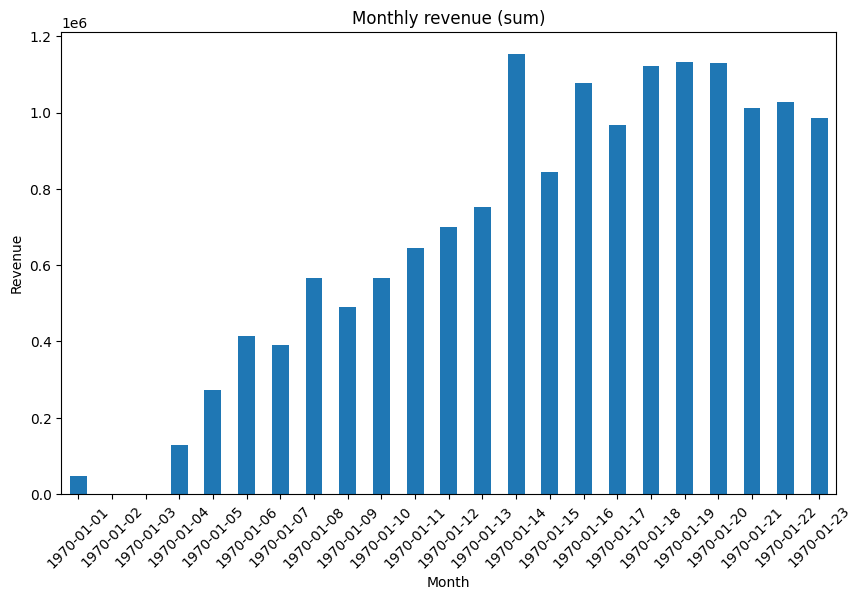

In [21]:
monthly = df.resample("M", on="order_date")['daily_revenue'].sum()

plt.figure(figsize=(10,6))
monthly.plot(kind="bar")
plt.title("Monthly revenue (sum)")
plt.ylabel("Revenue")
plt.xlabel("Month")
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m-%d"))
plt.xticks(rotation=45)
plt.savefig("../artifacts/images/forecasting_EDA/revenue_monthly.png", dpi=300, bbox_inches="tight")
plt.show()

##### NOTE: *Monthly revenue highlights the long-term growth trajectory of the platform, with fluctuations becoming more pronounced as the business scales. The overall pattern suggests that sales expansion was driven by platform adoption rather than recurring seasonal effects.*

In [22]:
spike_threshold = df["daily_revenue"].quantile(0.995)
df = df[df["daily_revenue"] <= spike_threshold]
df = df[(df["order_date"] >= "2017-02-01") & (df["order_date"] <= "2018-08-01")]

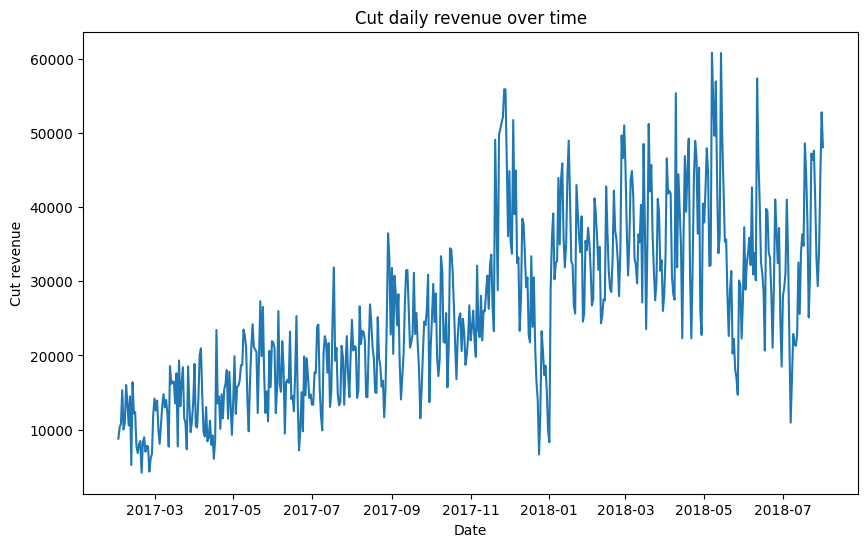

In [23]:
plt.figure(figsize=(10,6))
plt.plot(df['order_date'], df['daily_revenue'], color="tab:blue")
plt.title("Cut daily revenue over time")
plt.xlabel("Date")
plt.ylabel("Cut revenue")
plt.savefig("../artifacts/images/forecasting_EDA/cut_revenue_trend.png", dpi=300, bbox_inches="tight")
plt.show()

##### NOTE: *I decided to cut middle spike and time of periods with missing data.*